In [98]:
import pandas as pd
from sodapy import Socrata
import os
import requests
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
# Get Graffiti 311 Data from Chicago Data Portal API
graffiti_id = "cdmx-wzbz"
client = Socrata("data.cityofchicago.org", 'BOetEt3G4uynCIa1XQuFyRS8X')

g_results = client.get(graffiti_id, where="creation_date between '2017-01-01T00:00:00' and '2017-12-31T00:00:00'", limit = 2000000)
g_df = pd.DataFrame.from_records(g_results)
#g_df.drop(["what_type_of_surface_is_the_graffiti_on_", "where_is_the_graffiti_located_", "ssa"], axis = 1, inplace = True)


In [36]:
# Get Vacant and Abandoned Buildings 311 Data from Chicago Data Portal API
buildings_id = "yama-9had"
b_results = client.get(buildings_id, where="date_service_request_was_received between '2017-01-01T00:00:00' and '2017-12-31T00:00:00'", limit = 2000000)
b_df = pd.DataFrame.from_records(b_results)
b_df["street_address"] = b_df.address_street_number+" "+b_df.address_street_direction+" "+b_df.address_street_name+" "+b_df.address_street_suffix
#b_df.drop(["location_of_building_on_the_lot_if_garage_change_type_code_to_bgd_", "is_building_open_or_boarded_", 
          # "if_the_building_is_open_where_is_the_entry_point_", "is_the_building_currently_vacant_or_occupied_",
          # "is_the_building_vacant_due_to_fire_", "any_people_using_property_homeless_childen_gangs_", "address_street_number",
          # "address_street_direction", "address_street_name", "address_street_suffix"], axis = 1, inplace = True)
#b_df["completion_date"] = None
b_df.rename(index=str, columns={"date_service_request_was_received": "creation_date", "service_request_type": "type_of_service_request"}, inplace = True)


In [37]:
# Get Alley Lights Out 311 Data from Chicago Data Portal API
alleys_id = "j9pw-ad5p"
a_results = client.get(alleys_id, where="creation_date between '2017-01-01T00:00:00' and '2017-12-31T00:00:00'", limit = 2000000)
a_df = pd.DataFrame.from_records(a_results)

In [39]:
com_area_id = "igwz-8jzy"
ca_results = client.get(com_area_id)
ca_df = pd.DataFrame.from_records(ca_results)

In [40]:
ca_names = ca_df[["area_num_1", "community"]].copy()
ca_names.rename(index = str, columns = {"area_num_1": "community_area"}, inplace = True)

In [41]:
# Concatenate the 3 dataframes into one dataframe representing all 311 calls in 2017 on the 3 issues
all_call = pd.concat([g_df, b_df, a_df], axis = 0, ignore_index = True)
all_call = pd.merge(all_call, ca_names, on = 'community_area', how = 'left')
all_call['response_time'] = pd.to_datetime(all_call['completion_date']) - pd.to_datetime(all_call['creation_date'])

In [42]:
all_call['response_time'] = (pd.to_datetime(all_call['completion_date']) - pd.to_datetime(all_call['creation_date'])).dt.days

In [43]:
# Count number of service requests by type
all_call.groupby("type_of_service_request").size().reset_index(name="count")

,type_of_service_request,count
0,Alley Light Out,27896
1,Graffiti Removal,112779
2,Vacant/Abandoned Building,3666


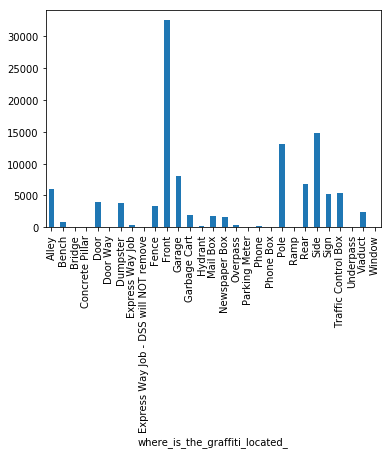

In [93]:
# Count number of Grafitti sub-type 
p1 = all_call.groupby(["where_is_the_graffiti_located_"]).size()
p1.plot.bar()

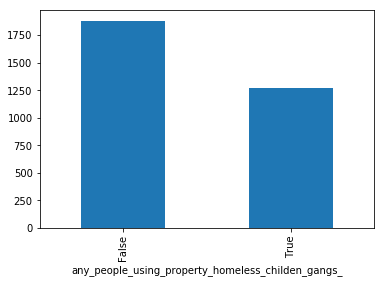

In [97]:
# Count number of abandoned building subtype
p1 = all_call.groupby(["any_people_using_property_homeless_childen_gangs_"]).size()
p1.plot.bar()

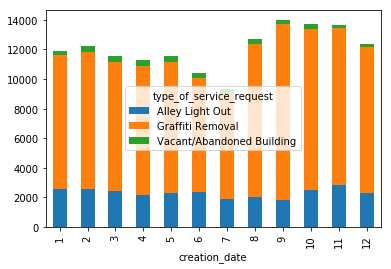

In [94]:
# Count number of service requests per month
pt = all_call.groupby([pd.to_datetime(all_call.creation_date).dt.month, all_call.type_of_service_request]).size().reset_index(name="count")
piv = pt.pivot(index='creation_date', columns='type_of_service_request', values='count')
piv.plot.bar(stacked= True)

In [25]:
# Count number of service requests by community area
grouped = all_call.groupby("community").size().reset_index(name="count")
grouped.sort_values(by = "count", ascending=False)

,community,count
75,WEST TOWN,10272
40,LOGAN SQUARE,8162
64,SOUTH LAWNDALE,6675
42,LOWER WEST SIDE,6216
11,BRIGHTON PARK,5784
7,AVONDALE,4751
37,LAKE VIEW,4730
43,MCKINLEY PARK,4693
26,GAGE PARK,3825
8,BELMONT CRAGIN,3744


In [32]:
grouped = all_call.groupby("community")['response_time'].mean().reset_index(name="average_response_time")
grouped.sort_values(by = "average_response_time", ascending=False)

,community,average_response_time
55,OAKLAND,43.829787
59,RIVERDALE,37.230769
45,MORGAN PARK,35.706320
73,WEST PULLMAN,32.679831
9,BEVERLY,31.305000
29,GREATER GRAND CROSSING,30.977099
14,CHATHAM,30.262887
6,AVALON PARK,30.225490
76,WOODLAWN,29.675373
65,SOUTH SHORE,28.497592


In [33]:
grouped = all_call.groupby("type_of_service_request")['response_time'].mean().reset_index(name="average_response_time")
grouped.sort_values(by= "average_response_time", ascending=False)

,type_of_service_request,average_response_time
0,Alley Light Out,33.489418
1,Graffiti Removal,0.676226
2,Vacant/Abandoned Building,NaN


**Question 1 Response**

The findings below illuminate several interesting trends about responses to 311 requests in the city of Chicago. I highlight five interesting things I learned performing this analysis below:
1. The city of Chicago receives vastly more graffiti removal requests than alley lights out requests or vacant building requests. This result likely indicates the higher incidence of graffiti than vacant buildings or alley lights out. 
2. There are significant disparities in the average response time to 311 calls in the city. The areas that experience the fastest response times tend to be of key commercial importance (such as the Loop or O'Hare Airport) or higher-income areas. The areas with the slowest response times tend to be lower-income areas.
3. There is a significant disconnect between the community areas that place the most 311 requests and the response time to 311 requests in those areas. This may reflect that citizens living in community areas with slow response times have become disenfranchised and do not expect the city to respond to their needs. 
4.
5.

In [136]:
# Query ACS Data
acs_results = requests.get('https://api.census.gov/data/2016/acs/acs5?get=NAME,B01003_001E,B02001_002E,B02001_003E,B15003_022E,B19001_001E&for=block%20group:*&in=state:17%20county:031&key=91aa6a44edb890abeea862f2d9befb5d520a5cc4')
data = acs_results.text
acs_df = pd.read_json(data)



NameError: name 'B01003_001E' is not defined

In [148]:
variables = {'B01003_001E': "total_pop", 'B02001_002E': "total_white", 'B02001_003E': "total_black", 'B15003_022E': "bachelors_degree", 'B19001_001E': "total_income"}
acs_df.columns = acs_df.iloc[0]
acs_df.drop([0], inplace = True)
acs_df.rename(columns = variables, inplace=True)

In [155]:
acs_df['pct_black'] = pd.to_numeric(acs_df['total_black'])/ pd.to_numeric(acs_df['total_pop'])
acs_df['pct_white'] = pd.to_numeric(acs_df['total_white'])/ pd.to_numeric(acs_df['total_pop'])
acs_df['pct_bachelors'] = pd.to_numeric(acs_df['bachelors_degree'])/ pd.to_numeric(acs_df['total_pop'])

In [156]:
acs_df[:10]


,NAME,total_pop,total_white,total_black,bachelors_degree,total_income,state,county,tract,block group,pct_black,pct_white,pct_bachelors
1,"Block Group 1, Census Tract 101, Cook County, ...",639,288,232,75,312,17,031,010100,1,0.363067,0.450704,0.117371
2,"Block Group 2, Census Tract 101, Cook County, ...",1768,676,1009,128,833,17,031,010100,2,0.570701,0.382353,0.072398
3,"Block Group 3, Census Tract 101, Cook County, ...",1981,1252,475,414,1061,17,031,010100,3,0.239778,0.632004,0.208985
4,"Block Group 1, Census Tract 102.01, Cook Count...",1417,588,656,242,619,17,031,010201,1,0.462950,0.414961,0.170783
5,"Block Group 2, Census Tract 102.01, Cook Count...",4641,1962,2319,554,1673,17,031,010201,2,0.499677,0.422754,0.119371
6,"Block Group 3, Census Tract 102.01, Cook Count...",974,558,373,160,430,17,031,010201,3,0.382957,0.572895,0.164271
7,"Block Group 1, Census Tract 102.02, Cook Count...",1114,474,324,164,456,17,031,010202,1,0.290844,0.425494,0.147217
8,"Block Group 2, Census Tract 102.02, Cook Count...",1161,623,411,238,535,17,031,010202,2,0.354005,0.536606,0.204996
9,"Block Group 1, Census Tract 103, Cook County, ...",1034,827,183,246,515,17,031,010300,1,0.176983,0.799807,0.237911
10,"Block Group 2, Census Tract 103, Cook County, ...",2026,1196,696,260,849,17,031,010300,2,0.343534,0.590326,0.128332
